## no_rag

### データセット

In [2]:
import json

with open("dataset/response.jsonl", "r") as f:
    res_data = [json.loads(l) for l in f.readlines()]
with open("dataset/source_info.jsonl", "r") as f:
    info_data = [json.loads(l) for l in f.readlines()]

In [3]:
id_list = [d["source_id"] for d in info_data]
len(id_list)

2965

In [49]:
train_data = []
test_data = []
for id in id_list:
    # reference
    for d in info_data[:]:
        if d["source_id"] == id:
            # print(d)
            task_type = d["task_type"]
            source = d["source"]
            ref = d["source_info"]
            info_data.remove(d)
            break
    # text
    num = 0
    for d2 in res_data[:]:
        if num == 6:
            break
        if d2["source_id"] == id:
            # print(d2)
            num += 1
            model_name = d2["model"]
            text = d2["response"]
            labels = 0 if d2["labels"] == [] else 1  # halってたら1
            data = {
                "ref": str(ref),
                "text": text,
                "labels": labels,
                "source": source,
                "model": model_name,
                "task_type": task_type,
                "source_id": id,
            }
            if d2["split"] == "train":
                train_data.append(data)
            else:
                test_data.append(data)
            res_data.remove(d2)

In [50]:
len(train_data), len(test_data)

(15090, 2700)

In [51]:
import json

with open("rag_truth_train.json", "w") as f:
    json.dump(train_data, f, indent=4)
with open("rag_truth_test.json", "w") as f:
    json.dump(test_data, f, indent=4)

### ここからでいい

In [1]:
import json

with open("rag_truth_train2.json", "r") as f:
    train_data = json.load(f)
with open("rag_truth_dev.json", "r") as f:
    dev_data = json.load(f)
with open("rag_truth_test.json", "r") as f:
    test_data = json.load(f)

In [2]:
# prefixをつける
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement as true or false: " + d["text"]
    return data


train_data = add_prefix(train_data)
dev_data = add_prefix(dev_data)
test_data = add_prefix(test_data)

In [12]:
# task_type: QA, Data2txt, Summary
task_name = "Summary"
train_data = [d for d in train_data if d["task_type"] == task_name]
dev_data = [d for d in dev_data if d["task_type"] == task_name]
test_data = [d for d in test_data if d["task_type"] == task_name]

In [3]:
from datasets import Dataset, DatasetDict
import pandas as pd

train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)
train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)
test_ds = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({"train": train_ds, "dev":dev_ds, "test": test_ds})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 13830
    })
    dev: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 2700
    })
})

In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding


#tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
'''
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"
'''
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large",use_fast=False)


def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
# tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

2024-12-26 14:08:40.187445: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 14:08:40.200603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 14:08:40.216377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-26 14:08:40.216405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 14:08:40.241492: I tensorflow/core/platform/cpu_feature_gua

Map:   0%|          | 0/13830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

In [5]:
from transformers import AutoModel
import torch
import accelerate
import bitsandbytes
import transformers


#base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")
base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
import torch

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
base_model.to(device)
device

device(type='cuda')

In [7]:
import torch
import torch.nn as nn
from transformers.modeling_outputs import ModelOutput
import os

loss_list = []


class NoRagModel(nn.Module):
    def __init__(self, base_model, question_encoder=None, generator=None):
        super(NoRagModel, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(base_model.config.hidden_size, 2)  # ラベル予測用の分類層
        #self.classifier = nn.Linear(96, 2)
        self.question_encoder = question_encoder
        self.generator = generator

    def forward(self, input_ids, attention_mask=None, labels=None):

        text_output = self.base_model(input_ids=input_ids, attention_mask=attention_mask)[0][:,-1,:]
        #text_output = text_output.mean(dim=1)
        #print(text_output.shape)
        text_output = self.dropout(text_output)

        # ラベル予測の出力
        logits = self.classifier(text_output)

        loss = nn.CrossEntropyLoss()(logits, labels) if labels is not None else None
        loss_list.append(loss)
        return ModelOutput(logits=logits, loss=loss)

    def save_pretrained(self, save_directory):
        """
        モデル全体とサブモジュールを保存するカスタムメソッド
        """
        os.makedirs(save_directory, exist_ok=True)

        # サブモジュールの保存
        if self.question_encoder is not None:
            self.question_encoder.save_pretrained(os.path.join(save_directory, "question_encoder"))
        if self.generator is not None:
            self.generator.save_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みを保存
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def from_pretrained(cls, save_directory):
        """
        保存済みモデルをロードするカスタムメソッド
        """
        question_encoder = None
        generator = None

        # サブモジュールのロード
        if os.path.exists(os.path.join(save_directory, "question_encoder")):
            question_encoder = AutoModel.from_pretrained(os.path.join(save_directory, "question_encoder"))
        if os.path.exists(os.path.join(save_directory, "generator")):
            generator = AutoModel.from_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みをロード
        model = cls(question_encoder=question_encoder, generator=generator)
        model.load_state_dict(torch.load(os.path.join(save_directory, "pytorch_model.bin")))

        return model

In [5]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1).tolist()  # ndarray をリストに変換
    labels = labels.tolist()  # ndarray をリストに変換

    # accuracy と f1 score を計算
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)
    precision = precision_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {"accuracy": accuracy, "recall": recall, "precision": precision, "f1": f1}

In [7]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModel, RobertaForSequenceClassification
import torch
from torch.nn.parallel import DataParallel
from models import NoRagModel

base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")
# モデルとトークナイザーを読み込む
name = "./1216_no_rag"
model = NoRagModel.from_pretrained(base_model, name)
#tokenizer = AutoTokenizer.from_pretrained(name)

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# training_args = TrainingArguments("test-trainer")
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="steps",
    save_steps=10000,
    learning_rate=1e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=12,
    logging_dir="./logs",
    report_to="tensorboard",
    optim="adafactor",
)

# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
#model = NoRagModel(base_model)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/19265.1.interactive/ipykernel_818753/3434745128.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

{'eval_loss': 1.659422755241394,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.7677777777777778,
 'eval_recall': 0.6786850477200425,
 'eval_precision': 0.6639004149377593,
 'eval_f1': 0.6712113266911379,
 'eval_runtime': 59.8342,
 'eval_samples_per_second': 45.125,
 'eval_steps_per_second': 11.281}

In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Recall,Precision,F1
0,0.558200,0.490070,0.004100,0.768254,0.633645,0.779310,0.698969
1,0.470700,0.473868,0.004100,0.775397,0.635514,0.794393,0.706127
2,0.368100,0.512860,0.004100,0.751587,0.695327,0.712644,0.703879
3,0.230300,0.576637,0.004100,0.764286,0.652336,0.758696,0.701508
4,0.110200,0.669687,0.004100,0.737302,0.699065,0.687500,0.693234
6,0.013000,0.999571,0.004100,0.754762,0.672897,0.728745,0.699708
7,0.002900,1.291256,0.004100,0.746825,0.650467,0.725000,0.685714
8,0.000700,1.576831,0.004100,0.750794,0.667290,0.724138,0.694553
9,0.000200,1.692229,0.004100,0.747619,0.657944,0.722793,0.688845


TrainOutput(global_step=2880, training_loss=0.17951998917204845, metrics={'train_runtime': 6193.292, 'train_samples_per_second': 22.331, 'train_steps_per_second': 0.465, 'total_flos': 0.0, 'train_loss': 0.17951998917204845, 'epoch': 9.994216310005784})

In [9]:
def create_dev_task(name):
    dev_data2 = [d for d in test_data if d["task_type"] == name]
    dev_df2 = pd.DataFrame(dev_data2)
    dev_ds2 = Dataset.from_pandas(dev_df2)
    tokenized_datasets_task = dev_ds2.map(tokenize_function, batched=True)
    tokenized_datasets_task = tokenized_datasets_task.remove_columns(["text"])
    return tokenized_datasets_task

In [10]:
dev_qa = create_dev_task("QA")
print(len(dev_qa))

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

900


In [11]:
trainer.evaluate(eval_dataset=dev_qa)

{'eval_loss': 1.2912269830703735,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.7977777777777778,
 'eval_recall': 0.5875,
 'eval_precision': 0.44761904761904764,
 'eval_f1': 0.5081081081081081,
 'eval_runtime': 19.817,
 'eval_samples_per_second': 45.416,
 'eval_steps_per_second': 11.354}

In [13]:
dev_d2t = create_dev_task("Data2txt")
print(len(dev_d2t))
trainer.evaluate(eval_dataset=dev_d2t)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

900


{'eval_loss': 1.7358759641647339,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.7822222222222223,
 'eval_recall': 0.8566493955094991,
 'eval_precision': 0.8144499178981938,
 'eval_f1': 0.835016835016835,
 'eval_runtime': 21.8293,
 'eval_samples_per_second': 41.229,
 'eval_steps_per_second': 10.307}

In [14]:
dev_sum = create_dev_task("Summary")
print(len(dev_sum))
trainer.evaluate(eval_dataset=dev_sum)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

900


{'eval_loss': 1.951164960861206,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.7233333333333334,
 'eval_recall': 0.24509803921568626,
 'eval_precision': 0.3448275862068966,
 'eval_f1': 0.28653295128939826,
 'eval_runtime': 18.196,
 'eval_samples_per_second': 49.461,
 'eval_steps_per_second': 12.365}

In [12]:
# トレーニング後にモデルを保存
name = "./1216_no_rag"
trainer.save_model(name)
trainer.save_state()
model.save_pretrained(name)



In [27]:
loss_list = [x.item() for x in loss_list]

In [28]:
len(loss_list)

38340

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


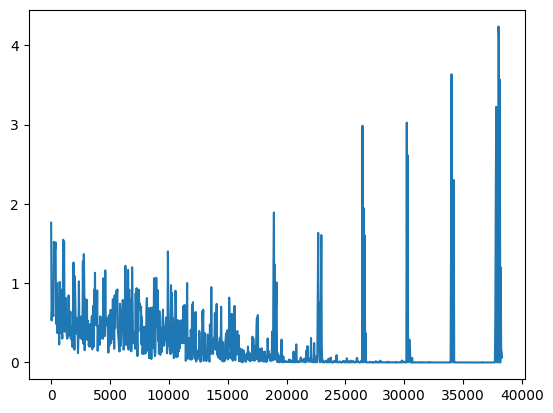

In [29]:
import matplotlib.pyplot as plt

x = np.arange(0, len(loss_list), len(loss_list) // 1000)
loss_list = np.array(loss_list)
plt.plot(x, loss_list[x])
plt.show()

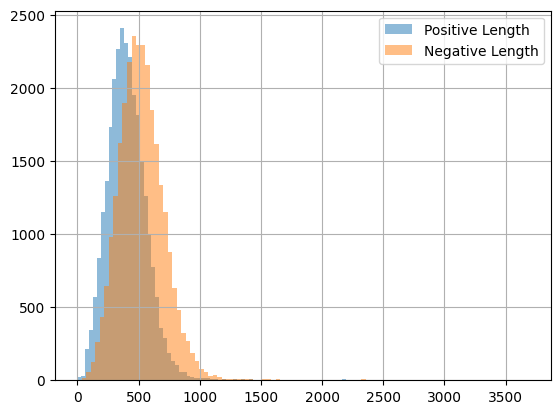

In [16]:
# 長さの分布
import matplotlib.pyplot as plt

train_true["text"].map(len).hist(alpha=0.5, label="Positive Length", bins=100)
train_false["text"].map(len).hist(alpha=0.5, label="Negative Length", bins=100)
plt.legend()
plt.show()

In [2]:
from transformers import AutoModel
from transformers import AutoTokenizer, DataCollatorWithPadding
import torch
"""
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")


# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
base_model.to(device)
"""
text = "I have a pen too"
tokenized_text = tokenizer(text)

# トークン化された結果の確認
#print(tokenized_text)

# input_ids と attention_mask を Tensor に変換
input_ids = torch.tensor(tokenized_text['input_ids']).unsqueeze(0).to(device)  # バッチ次元を追加
attention_mask = torch.tensor(tokenized_text['attention_mask']).unsqueeze(0).to(device)

# モデルに渡す
output = base_model(input_ids=input_ids, attention_mask=attention_mask)
print(output[0])

2024-11-22 15:23:29.031083: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 15:23:29.438053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 15:23:29.636103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 15:23:29.636553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 15:23:30.144176: I tensorflow/core/platform/cpu_feature_gua

NameError: name 'tokenizer' is not defined

In [73]:
output[1][0][0].shape

torch.Size([1, 32, 5, 96])

In [1]:
# Use a pipeline as a high-level helper
from transformers import pipeline

messages = [
    {"role": "user", "content": "I have a pen too"},
]
pipe = pipeline("text-generation", model="microsoft/Phi-3.5-mini-instruct", trust_remote_code=True)
pipe(messages)

2024-11-29 18:17:21.209763: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 18:17:21.642965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 18:17:21.852723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 18:17:21.853126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 18:17:22.226259: I tensorflow/core/platform/cpu_feature_gua

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/home/3/uw03923/nlp/lib64/python3.9/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.


[{'generated_text': [{'role': 'user', 'content': 'I have a pen too'},
   {'role': 'assistant',
    'content': " It seems like you're sharing a personal statement, possibly"}]}]

In [18]:
text = "I have a pen too"
tokenized_text = tokenizer(text)

# トークン化された結果の確認
#print(tokenized_text)

# input_ids と attention_mask を Tensor に変換
input_ids = torch.tensor(tokenized_text['input_ids']).unsqueeze(0).to(device)  # バッチ次元を追加
attention_mask = torch.tensor(tokenized_text['attention_mask']).unsqueeze(0).to(device)

# モデルに渡す
output = model(input_ids=input_ids, attention_mask=attention_mask)
print(output)

ModelOutput([('logits', tensor([[0.0058, 0.0235]], device='cuda:0', grad_fn=<AddmmBackward0>)), ('loss', None)])


### tokenにしたい

In [3]:
from transformers import AutoModel, AutoModelForCausalLM
from transformers import AutoTokenizer, DataCollatorWithPadding
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
base_model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3.5-mini-instruct")


# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
base_model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3SdpaAttention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMSNorm((3072,)

In [6]:
text = "I have a pen too"
tokenized_text = tokenizer(text)

# トークン化された結果の確認
#print(tokenized_text)

# input_ids と attention_mask を Tensor に変換
input_ids = torch.tensor(tokenized_text['input_ids']).unsqueeze(0).to(device)  # バッチ次元を追加
attention_mask = torch.tensor(tokenized_text['attention_mask']).unsqueeze(0).to(device)

# モデルに渡す
output = base_model.generate(
    input_ids=input_ids, 
    attention_mask=attention_mask,
    max_length=50,  # 最大長
    top_p=0.9,  # nucleus sampling（確率質量0.9）
    temperature=0.7,  # 温度（生成の多様性を調整）
    do_sample=True,  # サンプリングを有効にする
    no_repeat_ngram_size=2,  # 重複n-gramを避ける
    early_stopping=True  # 早期終了
)

print(output)

tensor([[  306,   505,   263,  6584,  2086, 29889,    13,    13,   797,   445,
         10541, 29892,   376, 29902,   505, 29908,   338,   278,  1667,  9750,
         29892,   322,   376, 29874,  6584, 29908,   322,   278,   758,  1066,
          3245, 16549,   376,   517, 29877, 29908,   526,   278,  3618, 29889,
           450,   758,  3283,   376,  2541, 29908,  3697,   278,  9443,  1546]],
       device='cuda:0')


In [7]:
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

I have a pen too.

In this sentence, "I have" is the main verb, and "a pen" and the prepositional phrase "too" are the objects. The preposition "with" shows the relationship between


In [2]:
# Use a pipeline as a high-level helper
from transformers import pipeline

prompt = """
Below is the original news:
Seventy years ago, Anne Frank died of typhus in a Nazi concentration camp at the age of 15. Just two weeks after her supposed death on March 31, 1945, the Bergen-Belsen concentration camp where she had been imprisoned was liberated -- timing that showed how close the Jewish diarist had been to surviving the Holocaust. But new research released by the Anne Frank House shows that Anne and her older sister, Margot Frank, died at least a month earlier than previously thought. Researchers re-examined archives of the Red Cross, the International Training Service and the Bergen-Belsen Memorial, along with testimonies of survivors. They concluded that Anne and Margot probably did not survive to March 1945 -- contradicting the date of death which had previously been determined by Dutch authorities. In 1944, Anne and seven others hiding in the Amsterdam secret annex were arrested and sent to the  Auschwitz-Birkenau concentration camp. Anne Frank\'s final entry. That same year, Anne and Margot were separated from their mother and sent away to work as slave labor at the Bergen-Belsen camp in Germany. Days at the camp were filled with terror and dread, witnesses said. The sisters stayed in a section of the overcrowded camp with no lighting, little water and no latrine. They slept on lice-ridden straw and violent storms shredded the tents, according to the researchers. Like the other prisoners, the sisters endured long hours at roll call. Her classmate, Nannette Blitz, recalled seeing Anne there in December 1944: "She was no more than a skeleton by then. She was wrapped in a blanket; she couldn\'t bear to wear her clothes anymore because they were crawling with lice." Listen to Anne Frank\'s friends describe her concentration camp experience. As the Russians advanced further, the Bergen-Belsen concentration camp became even more crowded, bringing more disease. A deadly typhus outbreak caused thousands to die each day. Typhus is an infectious disease caused by lice that breaks out in places with poor hygiene. The disease causes high fever, chills and skin eruptions. "Because of the lice infesting the bedstraw and her clothes, Anne was exposed to the main carrier of epidemic typhus for an extended period," museum researchers wrote. They concluded that it\'s unlikely the sisters survived until March, because witnesses at the camp said the sisters both had symptoms before February 7. "Most deaths caused by typhus occur around twelve days after the first symptoms appear," wrote  authors Erika Prins and Gertjan Broek. The exact dates of death for Anne and Margot remain unclear. Margot died before Anne. "Anne never gave up hope," said Blitz, her friend. "She was absolutely convinced she would survive." Her diary endures as one of the world\'s most popular books. Read more about Anne Frank\'s cousin, a keeper of her legacy.
Below is a summary of the news:
New research conducted by the Anne Frank House has revealed that Anne Frank and her sister Margot likely died in the Bergen-Belsen concentration camp at least a month earlier than previously believed. The researchers examined archives of the Red Cross, the International Training Service, and the Bergen-Belsen Memorial, as well as testimonies from survivors. Anne and Margot were separated from their mother and sent to work as slave labor in the camp, where they lived in overcrowded conditions with little water, sanitation, or food. The sisters contracted typhus, which was rampant in the camp, and are believed to have died before February 7, 2022. The exact dates of their deaths remain unclear, but witness accounts suggest that they had symptoms of the disease before then. The discovery has led to a reevaluation of the events surrounding Anne Frank's death and has prompted the Anne Frank House to issue a corrected statement regarding the date of her passing.
Your task is to identify and label any hallucinated statements in the summary that are unsupported or contradicted by the original news.
Then, compile the labeled hallucinated spans into a JSON list, with each list item representing a separate hallucinated span.
Output:
"""
messages = [
    {"role": "user", "content": prompt},
]
pipe = pipeline("text-generation", model="microsoft/Phi-3.5-mini-instruct", trust_remote_code=True)
pipe(messages,max_new_tokens=256)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'generated_text': [{'role': 'user',
    'content': '\nBelow is the original news:\nSeventy years ago, Anne Frank died of typhus in a Nazi concentration camp at the age of 15. Just two weeks after her supposed death on March 31, 1945, the Bergen-Belsen concentration camp where she had been imprisoned was liberated -- timing that showed how close the Jewish diarist had been to surviving the Holocaust. But new research released by the Anne Frank House shows that Anne and her older sister, Margot Frank, died at least a month earlier than previously thought. Researchers re-examined archives of the Red Cross, the International Training Service and the Bergen-Belsen Memorial, along with testimonies of survivors. They concluded that Anne and Margot probably did not survive to March 1945 -- contradicting the date of death which had previously been determined by Dutch authorities. In 1944, Anne and seven others hiding in the Amsterdam secret annex were arrested and sent to the  Auschwitz-Birke

In [1]:
!nvidia-smi

Sun Nov 24 21:16:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100                    On  |   00000000:04:00.0 Off |                    0 |
| N/A   28C    P0            149W /  699W |   43343MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----